In [1]:
import pandas as pd
from hkfold import HKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from keras.layers import PReLU
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from keras.models import load_model
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df.dropna()

In [52]:
features = [
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain',
    'temp', 'soil_temp', 'z', 'air_dens', 'virtual_temp',
    'wind',
    #'H', 'LE',
    #'lval',
    #'zL', 'ustar', 
]

target = 'phi_m'

test_ds = np.random.choice(df.ds.unique(), 18, replace=False)
test_mask = df.ds.isin(test_ds)

In [60]:
def get_data(mask, columns, merge_z_values):
    if merge_z_values:
        return np.vstack([
            np.hstack(g[columns].values)
            for _, g in df[mask].groupby(['ds', 'tt'])
        ])
    else:
        return df[mask][columns]


merge_z = True
train_x, train_y = get_data(~test_mask, features, merge_z), get_data(~test_mask, target, merge_z)
test_x, test_y = get_data(test_mask, features, merge_z), get_data(test_mask, target, merge_z)

#train_x, train_y = shuffle(train_x, train_y)
print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 393120, testing with 50244


In [61]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

norm_train_x = (train_x - mean_x) /  std_x
norm_test_x = (test_x - mean_x) / std_x

norm_train_y = (train_y - mean_y) / std_y
norm_test_y = (test_y - mean_y) / std_y

In [79]:
model = Sequential([
    Dense(1024, input_shape=(len(train_x[0]),)), PReLU(),
    Dense(1024), PReLU(),
    Dense(256), PReLU(),
    Dense(256), PReLU(),
    Dense(64), PReLU(),
    Dense(64), PReLU(),
    Dense(32), PReLU(),
    Dense(16), PReLU(),
    Dense(len(train_y[0]))
])

opt = RMSprop(lr=0.001)
model.compile(loss='mse', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 1024)              46080     
_________________________________________________________________
p_re_lu_84 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dense_102 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
p_re_lu_85 (PReLU)           (None, 1024)              1024      
_________________________________________________________________
dense_103 (Dense)            (None, 256)               262400    
_________________________________________________________________
p_re_lu_86 (PReLU)           (None, 256)               256       
_________________________________________________________________
dense_104 (Dense)            (None, 256)               65792     
__________

In [80]:
hist = model.fit(
    norm_train_x, norm_train_y,
    batch_size=1024, epochs=250,
    shuffle=True,
    callbacks=[
        ReduceLROnPlateau(factor=0.2, verbose=1, min_lr=1e-6),
        ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                        verbose=1, save_best_only=True),
        TensorBoard('dev/logs/', write_graph=False, write_grads=True),
        EarlyStopping(min_delta=0.0001, patience=50),
    ],
    validation_data=(norm_test_x, norm_test_y)
)

Train on 393120 samples, validate on 50244 samples
Epoch 1/250
392192/393120 [============================>.] - ETA: 0s - loss: 0.7086
Epoch 00001: val_loss improved from inf to 0.66939, saving model to dev/models/weights-w.0001-0.6694.hdf5
393120/393120 [==============================] - 11s 27us/step - loss: 0.7085 - val_loss: 0.6694
Epoch 2/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.6744
Epoch 00002: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.6745 - val_loss: 0.8222
Epoch 3/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.6754
Epoch 00003: val_loss improved from 0.66939 to 0.59848, saving model to dev/models/weights-w.0003-0.5985.hdf5
393120/393120 [==============================] - 9s 23us/step - loss: 0.6753 - val_loss: 0.5985
Epoch 4/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.6622
Epoch 00004: val_loss did not improve
393120/393120 [=================

Epoch 35/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.5462
Epoch 00035: val_loss did not improve
393120/393120 [==============================] - 9s 22us/step - loss: 0.5479 - val_loss: 0.5806
Epoch 36/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.5456
Epoch 00036: val_loss did not improve
393120/393120 [==============================] - 9s 22us/step - loss: 0.5455 - val_loss: 0.5000
Epoch 37/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.5355
Epoch 00037: val_loss did not improve
393120/393120 [==============================] - 9s 22us/step - loss: 0.5361 - val_loss: 0.5313
Epoch 38/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.5325
Epoch 00038: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.5328 - val_loss: 0.5180
Epoch 39/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.5368
Epoch 00039: val_loss improved from 0.4

Epoch 71/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.3011
Epoch 00071: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.3015 - val_loss: 0.4069
Epoch 72/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2982
Epoch 00072: val_loss did not improve
393120/393120 [==============================] - 9s 22us/step - loss: 0.2982 - val_loss: 0.4124
Epoch 73/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2948
Epoch 00073: val_loss did not improve
393120/393120 [==============================] - 9s 22us/step - loss: 0.2948 - val_loss: 0.4362
Epoch 74/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2911
Epoch 00074: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00074: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.2914 - val_loss: 0.4260
Epoch 75/250
391168/393120 [==============

Epoch 107/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2027
Epoch 00107: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.2028 - val_loss: 0.4846
Epoch 108/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2027
Epoch 00108: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.2026 - val_loss: 0.4877
Epoch 109/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2024
Epoch 00109: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.2026 - val_loss: 0.4848
Epoch 110/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2024
Epoch 00110: val_loss did not improve
393120/393120 [==============================] - 9s 23us/step - loss: 0.2025 - val_loss: 0.4871
Epoch 111/250
391168/393120 [============================>.] - ETA: 0s - loss: 0.2023
Epoch 00111: val_loss did not impr

In [66]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

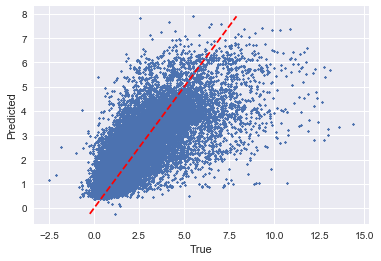

Explained variance 0.6182242210763684
Mean absolute error 0.6173660203515089
Mean squared error 1.018016735709469
Median absolute error 0.3532730259941834
R2 score 0.6180234215571526
Mean absolute percent error 74.75959819831358


In [78]:
best_model = load_model('dev/models/weights-w.0053-0.3767.hdf5')
y_pred = best_model.predict(norm_test_x)

# denormalize
test_deno = norm_test_y * std_y + mean_y
pred_deno = y_pred * std_y + mean_y

if merge_z:
    pred_deno = [y for ss in pred_deno for y in ss]
    test_deno = [y for ss in test_deno for y in ss]

plot_preds(pred_deno, test_deno)

print('Explained variance', metrics.explained_variance_score(test_deno, pred_deno))
print('Mean absolute error', metrics.mean_absolute_error(test_deno, pred_deno))
print('Mean squared error', metrics.mean_squared_error(test_deno, pred_deno))
print('Median absolute error', metrics.median_absolute_error(test_deno, pred_deno))
print('R2 score', metrics.r2_score(test_deno, pred_deno))
mape = 100 * sum(abs((yt - yp) / yt) for yt, yp in zip(test_deno, pred_deno)) / len(test_deno)
print('Mean absolute percent error', mape)